Using CUDA
Using SU(3)
Using double precision
Warm-up phase complete: 10000 steps discarded.

--- Statistical analysis for W_1x1 ---
  Number of data points             : 10000
  Mean                              : 0.593639
  Raw standard deviation s          : 0.001681
  Integrated autocorrelation time   : 125.69 ± 83.32
  Error (σ_τ)                       : 0.000266
  Error (σ_b)                       : 0.000062
  M                                 : 1099
  Sampling-Mean     (every 1000)    : 0.593514
  Sampling-Stddev.  (every 1000)    : 0.001208


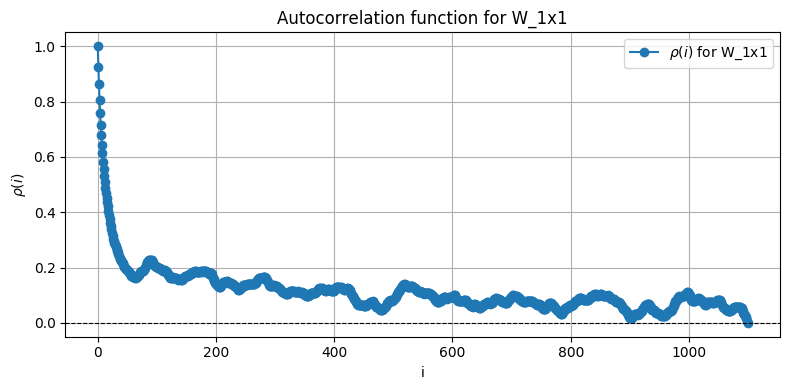


--- Statistical analysis for W_1x2 ---
  Number of data points             : 10000
  Mean                              : 0.383485
  Raw standard deviation s          : 0.002539
  Integrated autocorrelation time   : 184.61 ± 134.37
  Error (σ_τ)                       : 0.000488
  Error (σ_b)                       : 0.000095
  M                                 : 1325
  Sampling-Mean     (every 1000)    : 0.383518
  Sampling-Stddev.  (every 1000)    : 0.001471


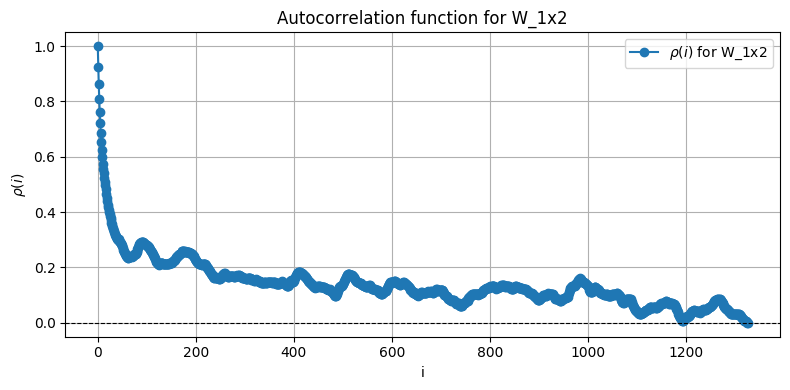


--- Statistical analysis for W_2x1 ---
  Number of data points             : 10000
  Mean                              : 0.383513
  Raw standard deviation s          : 0.002489
  Integrated autocorrelation time   : 142.80 ± 85.94
  Error (σ_τ)                       : 0.000421
  Error (σ_b)                       : 0.000092
  M                                 : 906
  Sampling-Mean     (every 1000)    : 0.383342
  Sampling-Stddev.  (every 1000)    : 0.002334


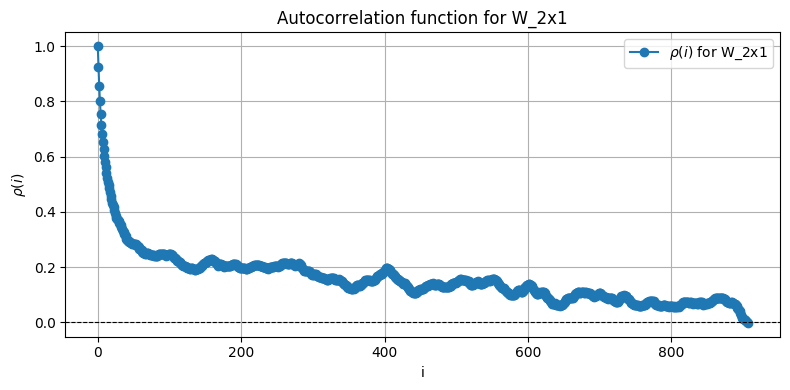


--- Statistical analysis for W_1x3 ---
  Number of data points             : 10000
  Mean                              : 0.252595
  Raw standard deviation s          : 0.002999
  Integrated autocorrelation time   : 274.09 ± 259.53
  Error (σ_τ)                       : 0.000702
  Error (σ_b)                       : 0.000109
  M                                 : 2242
  Sampling-Mean     (every 1000)    : 0.252416
  Sampling-Stddev.  (every 1000)    : 0.002137


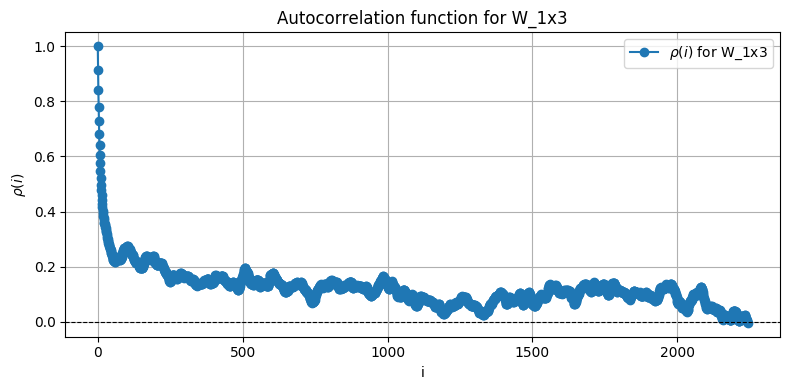


--- Statistical analysis for W_3x1 ---
  Number of data points             : 10000
  Mean                              : 0.252594
  Raw standard deviation s          : 0.002916
  Integrated autocorrelation time   : 164.99 ± 119.77
  Error (σ_τ)                       : 0.000530
  Error (σ_b)                       : 0.000105
  M                                 : 1318
  Sampling-Mean     (every 1000)    : 0.252596
  Sampling-Stddev.  (every 1000)    : 0.002983


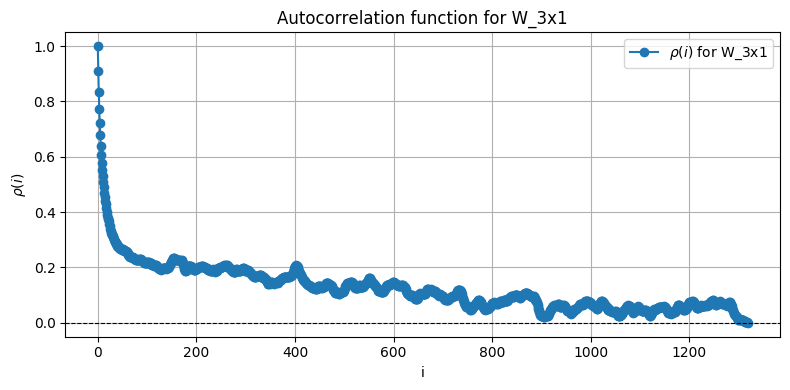


--- Statistical analysis for W_2x2 ---
  Number of data points             : 10000
  Mean                              : 0.189876
  Raw standard deviation s          : 0.002988
  Integrated autocorrelation time   : 390.37 ± 386.01
  Error (σ_τ)                       : 0.000835
  Error (σ_b)                       : 0.000116
  M                                 : 2445
  Sampling-Mean     (every 1000)    : 0.189877
  Sampling-Stddev.  (every 1000)    : 0.002747


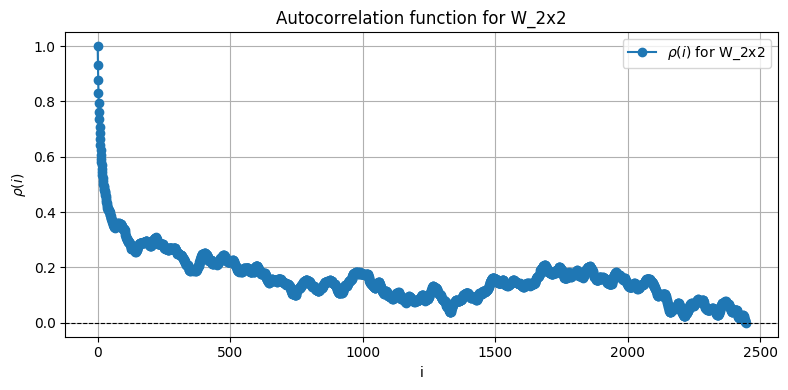


--- Statistical analysis for W_2x3 ---
  Number of data points             : 10000
  Mean                              : 0.101158
  Raw standard deviation s          : 0.002910
  Integrated autocorrelation time   : 430.19 ± 454.01
  Error (σ_τ)                       : 0.000854
  Error (σ_b)                       : 0.000108
  M                                 : 2785
  Sampling-Mean     (every 1000)    : 0.100561
  Sampling-Stddev.  (every 1000)    : 0.002694


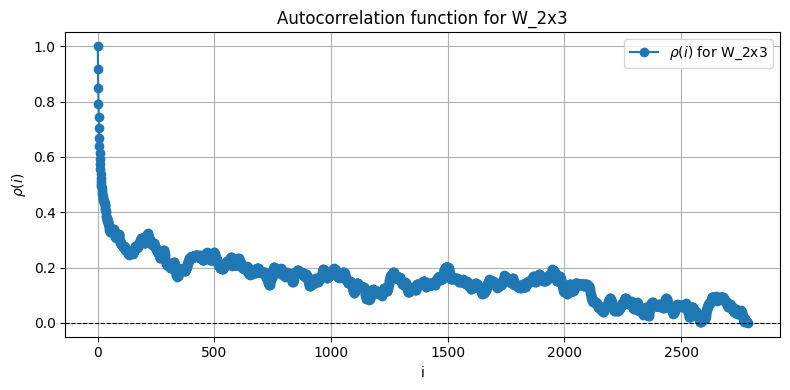


--- Statistical analysis for W_3x2 ---
  Number of data points             : 10000
  Mean                              : 0.101187
  Raw standard deviation s          : 0.002872
  Integrated autocorrelation time   : 403.43 ± 396.71
  Error (σ_τ)                       : 0.000816
  Error (σ_b)                       : 0.000108
  M                                 : 2418
  Sampling-Mean     (every 1000)    : 0.101067
  Sampling-Stddev.  (every 1000)    : 0.003244


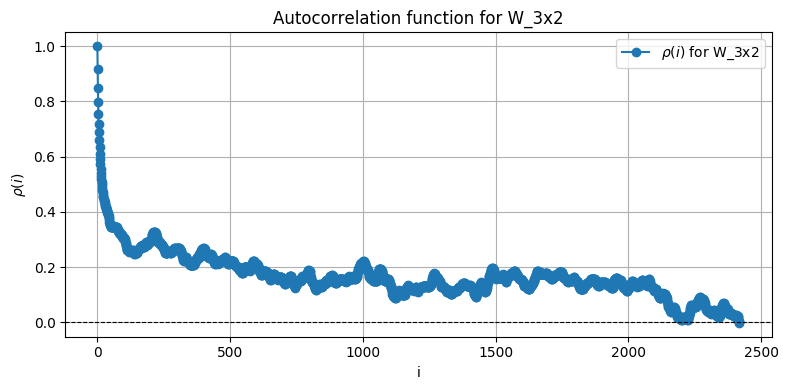


--- Statistical analysis for W_3x3 ---
  Number of data points             : 10000
  Mean                              : 0.046799
  Raw standard deviation s          : 0.002510
  Integrated autocorrelation time   : 351.58 ± 330.75
  Error (σ_τ)                       : 0.000665
  Error (σ_b)                       : 0.000090
  M                                 : 2213
  Sampling-Mean     (every 1000)    : 0.046119
  Sampling-Stddev.  (every 1000)    : 0.002161


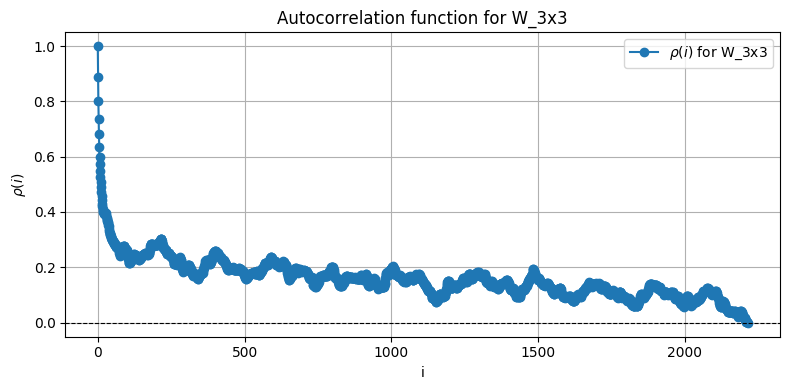


--- Statistical analysis for W_4x4 ---
  Number of data points             : 10000
  Mean                              : 0.010040
  Raw standard deviation s          : 0.001935
  Integrated autocorrelation time   : 114.36 ± 89.94
  Error (σ_τ)                       : 0.000293
  Error (σ_b)                       : 0.000057
  M                                 : 1547
  Sampling-Mean     (every 1000)    : 0.009200
  Sampling-Stddev.  (every 1000)    : 0.001484


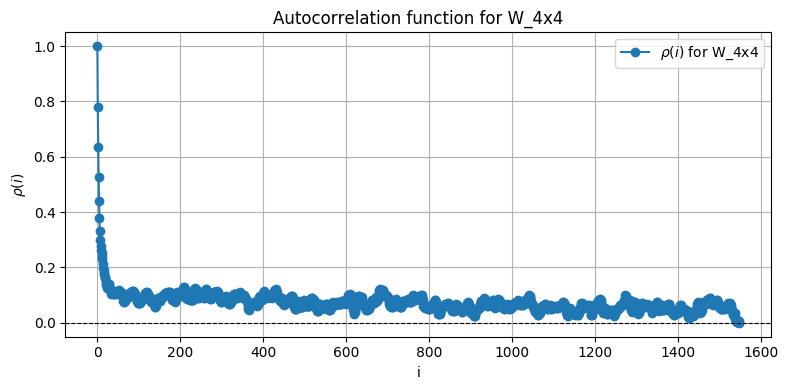

In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from lge_cnn.ym.core import Simulation

# --- Autocorrelation as explained in the thesis ---
def autocorrelation_until_zero(data):
    n = len(data)
    mean = np.mean(data)
    var = np.var(data)

    autocorr = []
    for t in range(n):
        gamma = np.sum((data[:n - t] - mean) * (data[t:] - mean)) / ((n - t) * var)
        autocorr.append(gamma)
        if t > 0 and gamma <= 0:
            break

    return np.array(autocorr)


def compute_tau_int_sokal(autocorr, N):
    """
    https://link.springer.com/chapter/10.1007/978-1-4899-0319-8_6
    """
    M = 1
    while M < len(autocorr):
        if autocorr[M] <= 0:
            break
        M += 1

    tau_int = 0.5 + np.sum(autocorr[1:M])
    delta_tau = np.sqrt((2 * (2 * (M-1) + 1)) / N) * tau_int

    return tau_int, delta_tau, M-1

# --- Blocking error ---
def blocking_error(data, num_blocks):
    data = np.asarray(data)
    N = len(data)
    block_size = N // num_blocks
    if block_size == 0:
        raise ValueError("Insufficient data points for the specified number of blocks.")

    block_means = []
    for i in range(num_blocks):
        start = i * block_size
        end = start + block_size
        block = data[start:end]
        block_mean = np.mean(block)
        block_means.append(block_mean)

    error = np.std(block_means) / np.sqrt(num_blocks)

    return error


# --- Simulation Parameters ---
dims = (12, 12, 12, 12)
beta = 6.0
seed = 42
steps = 10000
warmup_steps = 10000

# --- Initialize Simulation ---
sim = Simulation(dims, beta, seed)
sim.init(steps=10, use_flips=False)

# --- Observable Function ---
def measure_observable(n, m):
    return np.mean(sim.wilson_large(0, 1, n, m).real)

# --- Warm-up Phase ---
for _ in range(warmup_steps):
    sim.metropolis(1)
sim.copy_to_host()
print(f"Warm-up phase complete: {warmup_steps} steps discarded.")

# --- Observables ---
obs = {
    "W_1x1": [],
    "W_1x2": [],
    "W_2x1": [],
    "W_1x3": [],
    "W_3x1": [],
    "W_2x2": [],
    "W_2x3": [],
    "W_3x2": [],
    "W_3x3": [],
    "W_4x4": [],
}

# --- Run Simulation ---
for step in range(steps):
    sim.metropolis(1)
    obs["W_1x1"].append(measure_observable(1, 1))
    obs["W_1x2"].append(measure_observable(1, 2))
    obs["W_2x1"].append(measure_observable(2, 1))
    obs["W_1x3"].append(measure_observable(1, 3))
    obs["W_3x1"].append(measure_observable(3, 1))
    obs["W_2x2"].append(measure_observable(2, 2))
    obs["W_2x3"].append(measure_observable(2, 3))
    obs["W_3x2"].append(measure_observable(3, 2))
    obs["W_3x3"].append(measure_observable(3, 3))
    obs["W_4x4"].append(measure_observable(4, 4))

sim.copy_to_host()

# --- Analysis ---
for key, data in obs.items():
    autocorr = autocorrelation_until_zero(data)
    tau_int, tau_err, M = compute_tau_int_sokal(autocorr, N=len(data))

    # Error estimation with autocorrelation time σ_τ
    sokal_error = np.std(data) * np.sqrt(2 * tau_int / len(data))

    # Error estimation by blocking σ_b
    block_err = blocking_error(data, num_blocks=500)

    print(f"\n--- Statistical analysis for {key} ---")
    print(f"  Number of data points             : {len(data)}")
    print(f"  Mean                              : {np.mean(data):.6f}")
    print(f"  Raw standard deviation s          : {np.std(data, ddof=1):.6f}")
    print(f"  Integrated autocorrelation time   : {tau_int:.2f} ± {tau_err:.2f}")
    print(f"  Error (σ_τ)                       : {sokal_error:.6f}")
    print(f"  Error (σ_b)                       : {block_err:.6f}")
    print(f"  M                                 : {len(autocorr) - 1}")

    # --- Sampling every 1000 steps ---
    sampled = data[::1000]
    sampled = np.array(sampled)

    sampled_mean = np.mean(sampled)
    sampled_std = np.std(sampled, ddof=1)

    print(f"  Sampling-Mean     (every 1000)    : {sampled_mean:.6f}")
    print(f"  Sampling-Stddev.  (every 1000)    : {sampled_std:.6f}")
    
    # --- Plot autocorrelation function ---
    t_vals = np.arange(len(autocorr))
    plt.figure(figsize=(8, 4))
    plt.plot(t_vals, autocorr, marker='o', linestyle='-', label=f"$\\rho(i)$ for {key}")
    plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
    plt.title(f"Autocorrelation function for {key}")
    plt.xlabel("i")
    plt.ylabel(r"$\rho(i)$")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()